In [1]:
import torch
import matplotlib.pyplot as plt
from feedforward_np_version import Model_NP
from feedforward_pytorch_version import Model_Pytorch
import numpy as np
from torch import nn
import gzip
from torchvision import transforms
import os
np.random.seed(2023)

In [2]:
def display_mnist():
    data_train = MNISTDataset('./input/train', train=True)
    fig = plt.figure()

    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(data_train[i][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(data_train[i][1]))
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [3]:
class MNISTDataset():
    def __init__(self, data_path, train=True, transform=None):
        X, y = self.load_data(data_path, train)
        self.X = X
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        img = self.X[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.y is None:
            return img
        else:
            return img, int(self.y[index])

    def __len__(self):
        return len(self.X)

    def load_data(self, data_path, train):
        y_train = None

        if train:
            with gzip.open(data_path + '-labels.gz', 'rb') as f:
                y_train = np.frombuffer(f.read(), np.uint8, offset=8)

        with gzip.open(data_path + '-images.gz', 'rb') as f:
            x_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
        return x_train, y_train

In [4]:
def load_mnist():
    train_set = MNISTDataset('./input/train', train=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor()
                             ])
                             )
    test_set = MNISTDataset('./input/t10k', train=False,
                            transform=transforms.Compose([
                                transforms.ToTensor()
                            ])
                            )
    return train_set, test_set

In [5]:
def train_with_Model_NP(train_set, test_set):
    def compute_accuracy(log_prob, labels):
        predictions = np.argmax(log_prob, axis=1)
        truth = np.argmax(labels, axis=1)
        return np.sum(predictions == truth)

    _, width, height = train_set[0][0].shape
    model = Model_NP(width*height, 10)

    train_label = np.zeros(shape=[len(train_set), 10])
    #test_label = np.zeros(shape=[len(test_set), 10])
    train_label[np.arange(len(train_set)), np.array([train_set[i][1] for i in np.arange(len(train_set))])] = 1.
    #test_label[np.arange(len(test_set)), np.array([test_set[i][1] for i in np.arange(len(test_set))])] = 1.

    num_epochs = 100
    for epoch in range(1, num_epochs + 1):
        train_l_sum, train_acc_sum, n = 0., 0., 0

        X = np.concatenate([train_set[i][0] for i in np.arange(len(train_set))], axis = 0)
        y = train_label
        pred_y = model.forward(X)
        model.backward(y)
        model.update()
        loss = model.compute_loss(pred_y, y)
        accuracy = compute_accuracy(pred_y, y)

        train_l_sum += loss
        train_acc_sum += accuracy
        n += y.shape[0]

        if epoch % 10 == 0:
            print('epoch %d, loss %.4f, train acc %.3f'
                  % (epoch, train_l_sum / n, train_acc_sum / n)); # exit()

    X = np.stack([test_set[i][0] for i in np.arange(len(test_set))], axis = 0)
    h2_log = model.forward(X)
    predictions = np.argmax(h2_log, axis=1)
    pred_txt = [str(w) for w in predictions]
    g = open('output/predict.txt', 'w')
    g.write('\n'.join(pred_txt))
    g.close()


In [6]:
def train_with_Model_Pytorch(train_set, test_set):
    depth, width, height = train_set[0][0].shape

    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
    #test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=False)

    model = Model_Pytorch(width*height, 10)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    loss_func = nn.CrossEntropyLoss()

    num_epochs = 10
    for epoch in range(1, num_epochs + 1):
        train_l_sum, train_acc_sum, n = 0., 0., 0
        for X, y in train_dataloader:
            #print(y)
            y_hat = model(X).squeeze(1)
            loss = loss_func(y_hat, y.long()).sum()

            # 梯度清零
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_l_sum += loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]

        if epoch % 5 == 0:
            print('epoch %d, loss %.4f, train acc %.3f'
                % (epoch, train_l_sum / n, train_acc_sum / n))

In [7]:
def  zip_fun():
    path=os.getcwd()
    newpath=path+"/output/"
    os.chdir(newpath)
    os.system('zip prediction.zip predict.txt')
    os.chdir(path)


C:\Users\TheadoraTang\AppData\Local\Temp\ipykernel_18952\1455643602.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


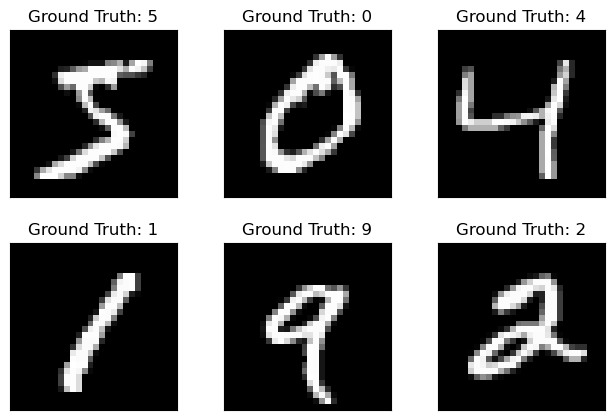

D:\anaconda\lib\site-packages\torchvision\transforms\functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


model with numpy ...
epoch 10, loss 0.0136, train acc 0.445
epoch 20, loss 0.0135, train acc 0.590
epoch 30, loss 0.0135, train acc 0.704
epoch 40, loss 0.0134, train acc 0.794
epoch 50, loss 0.0134, train acc 0.785
epoch 60, loss 0.0133, train acc 0.879
epoch 70, loss 0.0133, train acc 0.886
epoch 80, loss 0.0133, train acc 0.890
epoch 90, loss 0.0133, train acc 0.890
epoch 100, loss 0.0133, train acc 0.892


FileNotFoundError: [Errno 2] No such file or directory: 'output/predict.txt'

In [8]:
if __name__ == '__main__':
    train_set, test_set = load_mnist()

    display_mnist()

    train_with_Model_NP(train_set, test_set)

    train_with_Model_Pytorch(train_set, test_set)
    
    zip_fun()